# Analyse de la Varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de la varicelle sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.
La base de donnees a ete telechargee a cette adresse https://www.sentiweb.fr/datasets/incidence-PAY-7.csv?v=ater7.

In [2]:
import os
os.chdir(os.getcwd())
data_url = "../Source/20240110_incidence-PAY-7.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202352          7  13369     8309   18429      20          12   
1     202351          7   6940     4244    9636      10           6   
2     202350          7   8799     6215   11383      13           9   
3     202349          7   7817     5362   10272      12           8   
4     202348          7   7351     4749    9953      11           7   
...      ...        ...    ...      ...     ...     ...         ...   
1721  199101          7  15565    10271   20859      27          18   
1722  199052          7  19375    13295   25455      34          23   
1723  199051          7  19080    13807   24353      34          25   
1724  199050          7  11079     6660   15498      20          12   
1725  199049          7   1143        0    2610       2           0   

      inc100_up geo_insee geo_name  
0            28        FR   France  
1            14        FR   France  
2            17        FR   France  
3            16        FR   France  
4            15        FR   France  
...         ...       ...      ...  
1721         36        FR   France  
1722         45        FR   France  
1723         43        FR   France  
1724         28        FR   France  
1725          5        FR   France  

[1726 rows x 10 columns]

Y a-t-il des points manquants dans ce jeux de données ? Non aucune

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [7]:
sorted_data = data.set_index('period').sort_index()
sorted_data

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   
...                       ...        ...    ...      ...     ...     ...   
2023-11-27/2023-12-03  202348          7   7351     4749    9953      11   
2023-12-04/2023-12-10  202349          7   7817     5362   10272      12   
2023-12-11/2023-12-17  202350          7   8799     6215   11383      13   
2023-12-18/2023-12-24  202351          7   6940     4244    9636      10   
2023-12-25/2023-12-31  202352          7  13369     8309   18429      20   

                       inc100_low  inc100_up geo_insee geo_name  
period                                                           
1990-12-03/1990-12-09           0          5        FR   France  
1990-12-10/1990-12-16          12         28        FR   France  
1990-12-17/1990-12-23          25         43        FR   France  
1990-12-24/1990-12-30          23         45        FR   France  
1990-12-31/1991-01-06          18         36        FR   France  
...                           ...        ...       ...      ...  
2023-11-27/2023-12-03           7         15        FR   France  
2023-12-04/2023-12-10           8         16        FR   France  
2023-12-11/2023-12-17           9         17        FR   France  
2023-12-18/2023-12-24           6         14        FR   France  
2023-12-25/2023-12-31          12         28        FR   France  

[1726 rows x 10 columns]

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste.

In [8]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

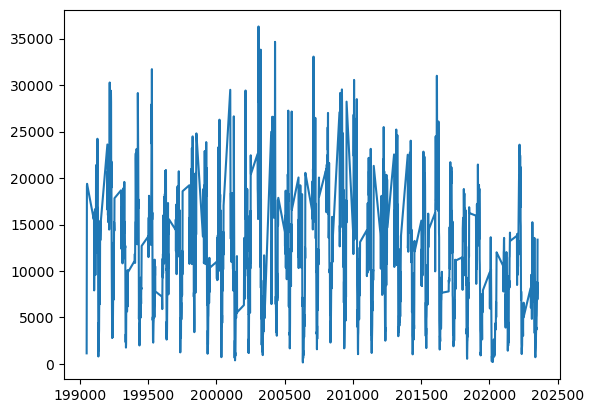

<Axes: xlabel='period'>

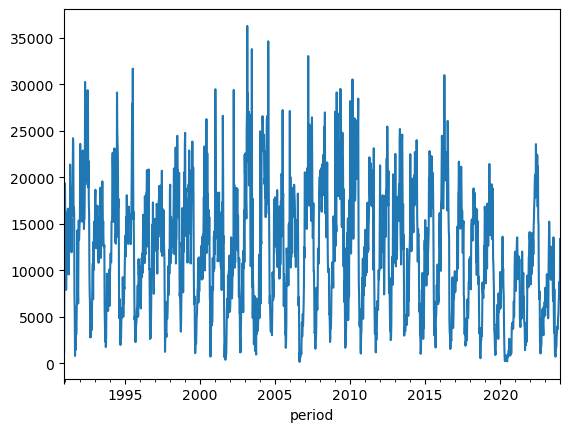

In [9]:
plt.plot(sorted_data['week'],sorted_data['inc'])
plt.show()
sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en été.

<Axes: xlabel='period'>

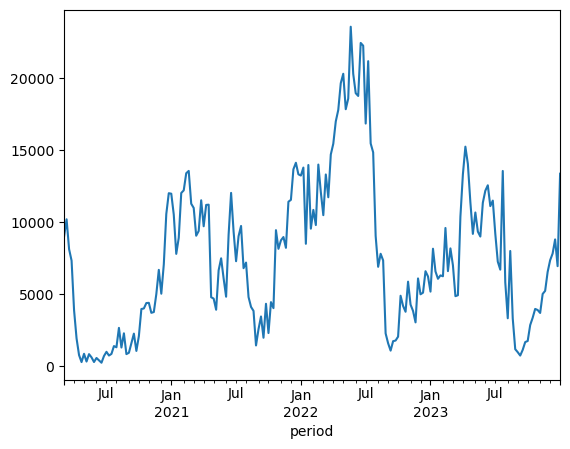

In [11]:
sorted_data['inc'][-200:].plot()

## Etude du Nombre de Cas par Annee

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de nombre de cas, du 1er août de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er septembre.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent en decembre 1991, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1992.

In [19]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1992,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er août, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [21]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

<Axes: >

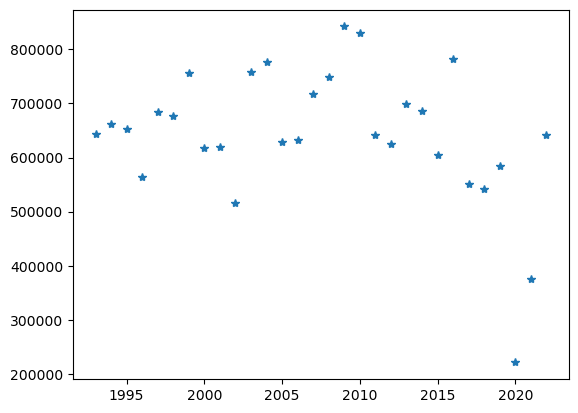

In [22]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [23]:
yearly_incidence.sort_values()

2020    221186
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2022    641397
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
2009    842373
dtype: int64

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent environ 10% de la population
  française, sont assez rares: il y en eu trois au cours des 35 dernières années.

<Axes: >

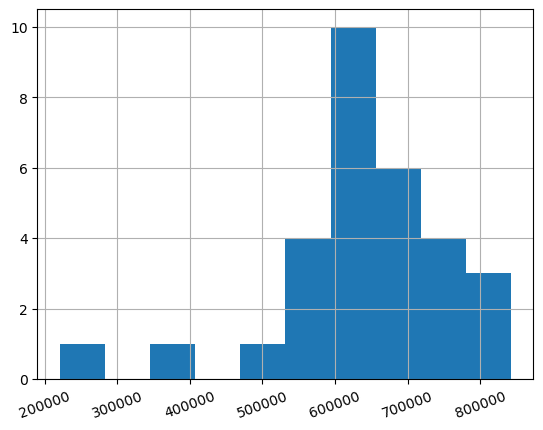

In [24]:
yearly_incidence.hist(xrot=20)